In [1]:
using JuMP
using Ipopt
using Plots
using CSV
using DataFrames;

In [2]:
β = 0.5 # infectivity rate
γ = 0.25 # recovery rate
υ_max = 0.5 # maximum intervention
υ_total = 10.0; # maximum cost


t0 = 0.0
tf = 100.0
dt = 2.0;


S₀ = 0.99
I₀ = 0.01
C₀ = 0.00;

T = Int(tf/dt);

In [3]:

model = Model(Ipopt.Optimizer);

In [4]:
set_optimizer_attribute(model, "output_file", "JuMP_ipopt_log.txt")
set_optimizer_attribute(model, "print_level", 5)
set_optimizer_attribute(model, "print_timing_statistics", "yes");


In [5]:
@variable(model, 0 <= S[1:(T+1)] <= 1)
@variable(model, 0 <= I[1:(T+1)] <= 1)
@variable(model, 0 <= C[1:(T+1)] <= 1)
@variable(model, 0 <= υ[1:(T+1)] <= υ_max)
@variable(model, infection[1:T] >= 0)
@variable(model, recovery[1:T] >= 0);

In [6]:
# Initial conditions
@constraint(model, S[1]==S₀)
@constraint(model, I[1]==I₀)
@constraint(model, C[1]==C₀);

In [7]:
# Constraints
@constraint(model, dt * sum(υ[t] for t in 1:T+1) <= υ_total);

@constraint(model, [t=1:T], infection[t] == (1 - exp(-(1 - υ[t]) * β * I[t] * dt)) * S[t])
@constraint(model, [t=1:T], recovery[t] == (1 - exp(-γ * dt)) * I[t]);


@constraint(model, [t=1:T], S[t+1] == S[t] - infection[t])
@constraint(model, [t=1:T], I[t+1] == I[t] + infection[t] - recovery[t])
@constraint(model, [t=1:T], C[t+1] == C[t] + infection[t]);

In [8]:

@objective(model, Min, C[T+1]);


In [9]:

optimize!(model)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      803
Number of nonzeros in inequality constraint Jacobian.:       51
Number of nonzeros in Lagrangian Hessian.............:      300

Total number of variables............................:      304
                     variables with only lower bounds:      100
                variables with lower and upper bounds:      204
                     variables with only upper bounds:        0
Total number of equality constraints.................:      253
Total number of inequality c

In [10]:
S_opt = value.(S)
I_opt = value.(I)
C_opt = value.(C)
υ_opt = value.(υ)
ts = collect(0:dt:tf);

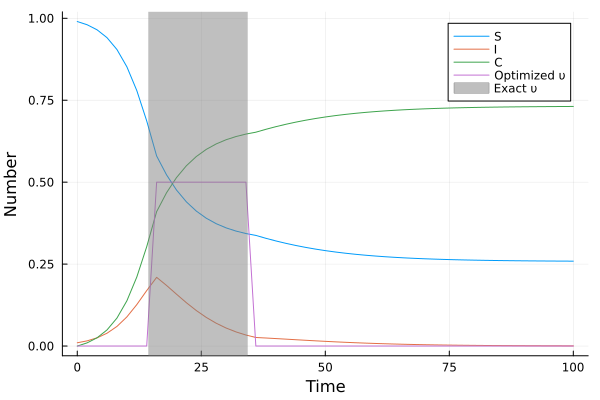

In [11]:
t₁ = 14.338623046875002
t₂ = t₁ + υ_total/υ_max


plot(ts, S_opt, label="S", xlabel="Time", ylabel="Number")
plot!(ts, I_opt, label="I")
plot!(ts, C_opt, label="C")
plot!(ts, υ_opt, label="Optimized υ")
vspan!([t₁, t₂], color=:gray, alpha=0.5, label="Exact υ")


In [12]:
CSV.write("jump_results.csv", DataFrame(timestep=1:T+1, S=S_opt, I=I_opt, C=C_opt, υ=υ_opt))

"jump_results.csv"